# Milestones 2 Phase 2 

Nama : William

Batch : RMT-020

Dataset : Dataset yang dipakai untuk project ini berisikan waktu dan tanggal , nama user ,  tweet yang dibuat, serta jenis sentimen dari tweet

Objective : Pada tahun 2020 tepatnya pada 2 maret 2020, kasus corona pertama kali muncul di Indonesia lalu terjadi penambahan kasus tiap hari nya. Untuk menangani hal itu, pemerintah menerapkan kebijakan Lockdown (PPKM) agar penyebaran Corona dapat ditekan. akan tetapi Pemerintah ingin melihat respon masyarakat terhadap kebijakan PPKM yang diberlakukan. maka disini pemerintah telah mengumpulkan respon masyarakat dalam bentuk Tweet pada aplikasi twitter. hal ini dilakukan agar pemerintah dapat memberlakukan kebijakan Lockdown dengan mempertimbangkan respon masyarakat terhadap kebijakan sebelumnya

# Import Libraries

In [6]:
# Import Library yang akan digunakan
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, Dropout , BatchNormalization , GRU
from keras.regularizers import l2
import tensorflow_hub as hub
from keras.layers import Reshape , Bidirectional , Activation
from sklearn.metrics import confusion_matrix
import joblib
import pickle
from tensorflow.keras.models import load_model
import ast
import inspect


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Loading

In [6]:
df = pd.read_csv('INA_TweetsPPKM_Labeled_Pure.csv', on_bad_lines='skip', delimiter='\t')    # Load Data yang akan digunakan
df

,Date,User,Tweet,sentiment
0,2022-03-31 14:32:04+00:00,pikobar_jabar,Ketahui informasi pembagian #PPKM di wilayah J...,1
1,2022-03-31 09:26:00+00:00,inewsdotid,Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...,1
2,2022-03-31 05:02:34+00:00,vdvc_talk,"Juru bicara Satgas Covid-19, Wiku Adisasmito m...",1
3,2022-03-30 14:23:10+00:00,pikobar_jabar,Ketahui informasi pembagian #PPKM di wilayah J...,1
4,2022-03-30 11:28:57+00:00,tvOneNews,Kementerian Agama menerbitkan Surat Edaran Nom...,1
...,...,...,...,...
23639,2020-06-26 18:34:56+00:00,bananabluff,noelle loses a bet to akarsha and it somehow e...,1
23640,2020-06-19 15:14:07+00:00,Auqroix,they call her... weekeeshee...\n#butterflysoup...,1
23641,2020-06-18 23:45:26+00:00,Auqroix,"put out what you wanna see more of, amirite ga...",1
23642,2020-06-15 23:17:22+00:00,Auqroix,"i don't need anybody, i'm fine here on my own\...",1


In [7]:
df.duplicated().sum() # Mengecek apakah ada data duplikasi

0

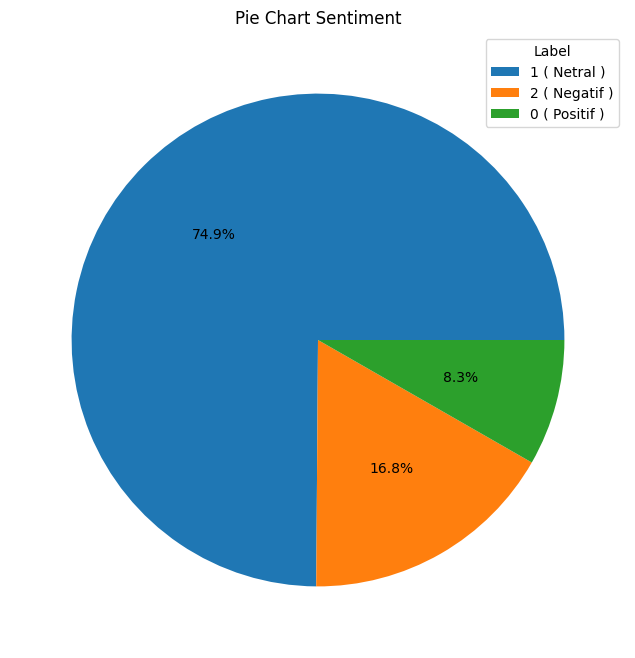

In [8]:
plt.figure(figsize=(16, 8))
plt.pie(df['sentiment'].value_counts(),autopct='%1.1f%%') # Mengecek Jumlah sentiment yang ada pada data
# Menambahkan judul
plt.title('Pie Chart Sentiment')

# Menambahkan legenda
plt.legend(title='Label', labels=('1 ( Netral )','2 ( Negatif )','0 ( Positif )'), loc='best')

disini saya mengecek data yang ada pada kolom sentiment dimana nantinya kolom ini akan digunakan sebagai target dari pemodelan. setelah di cek ternyata pada data ini sentimen 1 ( netral ) jumlah nya jauh lebih banyak dibandingkan sentimen yang lain. hal ini dapat menyebabkan model prediksi yang akan dibuat nantinya memiliki kecenderungan hasil prediksinya kurang bagus. jadi step yang saya ambil ialah melakukan undersampling. saya mengurangi jumlah sentimen 1 sehingga jumlah nya mirip dengan kedua sentimen lainnya

In [9]:
sen_0 = df[df['sentiment'] == 0] # Mengelompokkan data yang memiliki sentimen 0 ( positif )
sen_1 = df[df['sentiment'] == 1] # Mengelompokkan data yang memiliki sentimen 1 ( netral )
sen_2 = df[df['sentiment'] == 2] # Mengelompokkan data yang memiliki sentimen 2 ( Negatif )

In [10]:
# Undersampling kelas mayoritas (kelas 1)
undersampled_sen_1 = sen_1.sample(n=len(sen_2), random_state=9)
undersampled_sen_1

,Date,User,Tweet,sentiment
568,2022-02-13 07:43:50+00:00,PemKabTangerang,Bupati Zaki didampingi Kapolres Tangerang Sela...,1
18608,2021-07-06 08:53:20+00:00,OnlineshopMu,Peci Muhammadiyah Gold Classic: Songkok AC Bor...,1
22055,2021-02-12 06:19:53+00:00,PolresTts,"Sambangi aparat Desa Muna, Polri ajak berperan...",1
19614,2021-07-04 06:00:09+00:00,VIVAcoid,"Koordinator PPKM Darurat Jawa dan Bali, Luhut ...",1
23397,2021-01-11 08:44:22+00:00,murianewscom,"PPKM, Kudus Tutup 107 Tempat Wisata Selama Dua...",1
...,...,...,...,...
7451,2021-08-14 16:20:24+00:00,BantengGirl,Anton Minta Beras Bulog Berkerikil Tidak Dipol...,1
1997,2021-12-01 05:22:57+00:00,MFAnolyte,Saya menjual Disinfectant Anolyte ... seharga ...,1
8520,2021-08-10 01:36:15+00:00,imigrasiktp,Pelarangan masuk bagi orang asing dan penghent...,1
19712,2021-07-03 15:52:11+00:00,egyhahmad10,#ppkm\n#citayam https://t.co/DpMH4N8IQq,1


In [11]:
# # Undersampling kelas mayoritas (kelas 1)
# undersampled_sen_2 = sen_2.sample(n=len(sen_0), random_state=9)
# undersampled_sen_2

setelah melakukan undersampling, kemudian saya menggabungkan kembali ketiga sentimen ini menjadi 1 dataframe

In [12]:
# Gabungkan kembali data
data_undersampled = pd.concat([undersampled_sen_1, sen_0,sen_2])

# Acak ulang urutan data
data_undersampled = data_undersampled.sample(frac=1, random_state=42).reset_index()
df_new = data_undersampled.drop('index',axis=1)
df_new


,Date,User,Tweet,sentiment
0,2021-12-01 05:25:23+00:00,MFAnolyte,Saya menjual Anolyte AG Jerigen 5... seharga R...,1
1,2021-07-04 00:42:29+00:00,Andri_5151,"daripada gabut mikirin copat copit terus, yuk ...",2
2,2021-08-30 15:26:44+00:00,Kidut_Jr,#PPKM #PelanPelanKitaMeninggal #PerutPerihKura...,1
3,2021-07-20 07:36:07+00:00,InfoJogja1,Keputusan Pelik PPMK Diperpanjang atau Tidak??...,1
4,2021-08-13 04:27:05+00:00,temanerzaldiro1,Para nakes garda terdepan perjuangan melawan C...,0
...,...,...,...,...
9913,2021-07-04 19:01:05+00:00,mifreakmans21,"Nyari kerja itu mudah, cuma yang agak sulit me...",0
9914,2021-07-19 07:23:36+00:00,alineadotid,"Juru Bicara Vaksinasi Kemenkes, Siti Nadia Tar...",0
9915,2021-07-14 09:03:49+00:00,TaylorFineGoods,Selama masa PPKM gini kalian coba hobi baru ga...,0
9916,2021-01-11 07:43:48+00:00,murianewscom,Jam Operasional Pasar di Kudus Tetap Sama Sela...,1


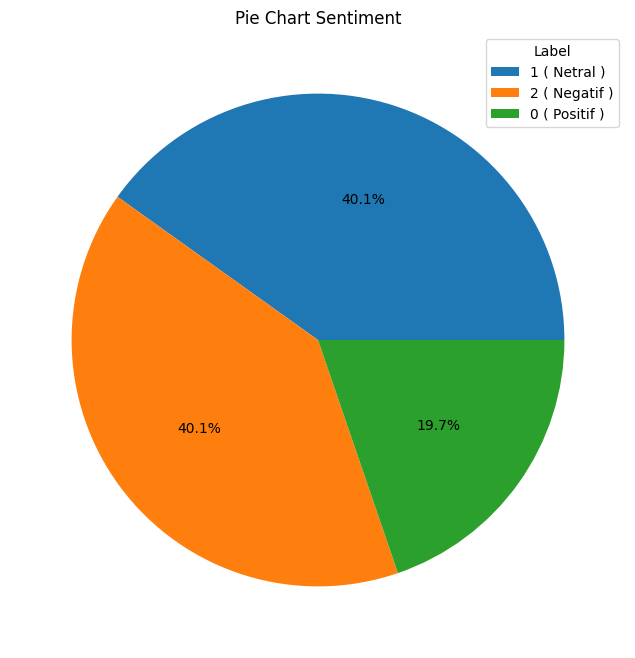

In [13]:
plt.figure(figsize=(16, 8))
plt.pie(df_new['sentiment'].value_counts(),autopct='%1.1f%%') # Mengecek Jumlah sentiment yang ada pada data
# Menambahkan judul
plt.title('Pie Chart Sentiment')

# Menambahkan legenda
plt.legend(title='Label', labels=('1 ( Netral )','2 ( Negatif )','0 ( Positif )'), loc='best')

setelah dilakukan undersampling, data yang dimiliki telah balance

# EDA sebelum Preprocessing

## Wordcloud Keseluruhan

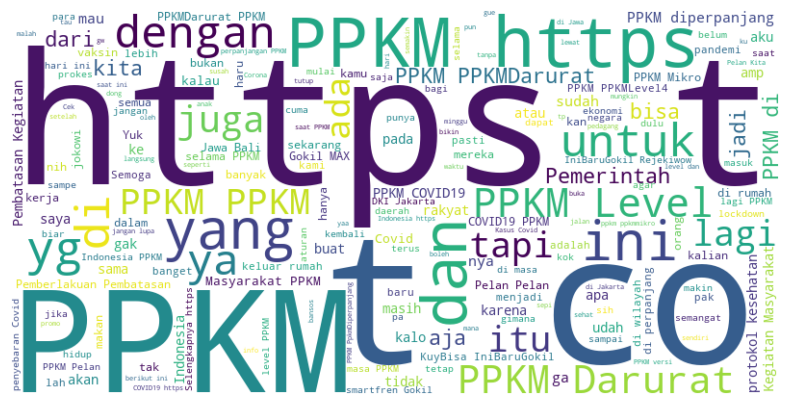

In [14]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text1 = " ".join(df_new['Tweet'])

# Membuat objek WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text1)

# Menampilkan wordcloud menggunakan matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

pada data yang belum dilakukan preprocessing, kata-kata yang paling banyak muncul ialah berupa link yang disertakan oleh tweet itu sendiri ditandai dengan adanya https, T , co, ini merupakan link yang biasa digunakan seseorang ketika membuat tweet dan menyertakan referensi dari tempat lain

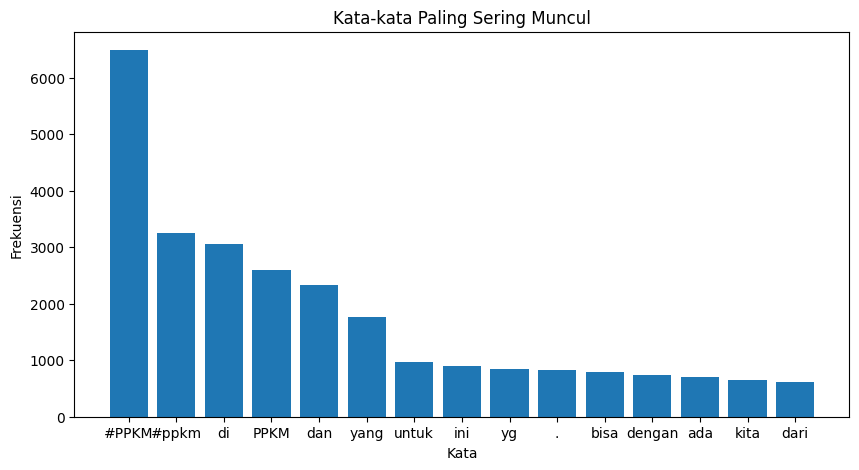

In [15]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text = " ".join(df_new['Tweet'])
words = text.split()  # Memisahkan teks menjadi kata-kata
# Hitung frekuensi kemunculan setiap kata
word_freq = Counter(words)

# Ambil N kata paling sering muncul
N = 15
most_common_words = word_freq.most_common(N)

# Buat plot untuk menampilkan kata-kata paling sering muncul
plt.figure(figsize=(10, 5))
plt.bar(*zip(*most_common_words))
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Kata-kata Paling Sering Muncul')
plt.show()

dapat dilihat bahwa secara keseluruhan, penggunaan tagar, kata preposisi, dan tanda baca merupakan kata yang paling sering muncul pada data sebelum dilakukan pembersihan

```
UNTUK PENGGUNAAN LINK HTTPS,T,CO, KENAPA TIDAK ADA SAAT PLOTTING ITU DIKARENAKAN SAAT KATA-KATA YANG ADA DI SPLIT, HTTPS,T,DAN CO IKUT MENJADI SEBUAH KATA BERSAMA DENGAN LINK YANG DISERTAKAN
```

## WordCloud Positif

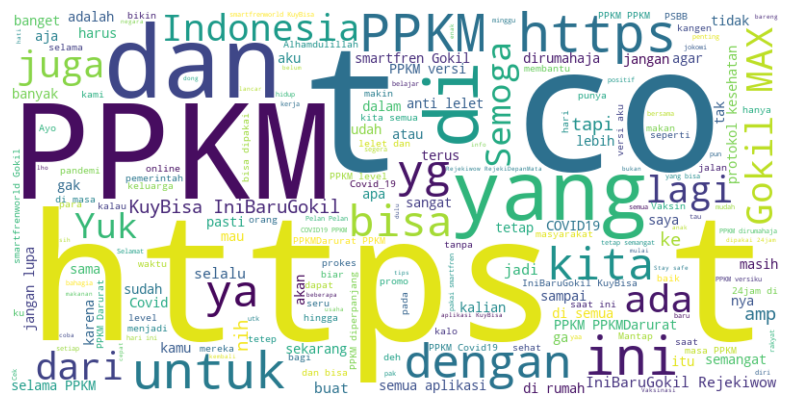

In [16]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text = " ".join(sen_0['Tweet'])

# Membuat objek WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Menampilkan wordcloud menggunakan matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

pada sentimen positif, kata dengan kemunculan terbesar masih ada pada awalan link seperti https,t,dan co, tetapi dapat dilihat juga bahwa pada wordcloud ini juga diisi oleh beberapa kata positif seperti "bisa","Alhamdulillah","KuyBisa","IniBaruGokil" yang merupakan kata-kata dengan vibes / pembawaan yang optimis / positif

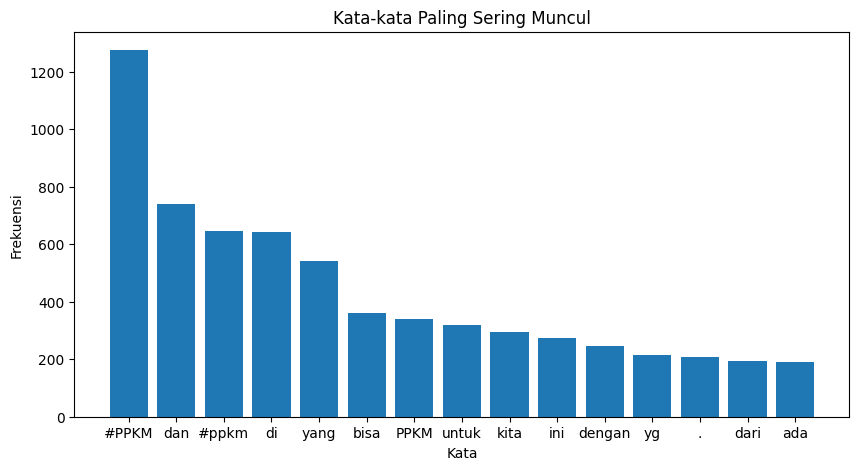

In [17]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text = " ".join(sen_0['Tweet'])
words = text.split()  # Memisahkan teks menjadi kata-kata
# Hitung frekuensi kemunculan setiap kata
word_freq = Counter(words)

# Ambil N kata paling sering muncul
N = 15
most_common_words = word_freq.most_common(N)

# Buat plot untuk menampilkan kata-kata paling sering muncul
plt.figure(figsize=(10, 5))
plt.bar(*zip(*most_common_words))
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Kata-kata Paling Sering Muncul')
plt.show()

pada sentimen positif, kata-kata dengan kemunculan yang paling sering ialah :

• Tagar yang merepresentasikan topik yang sedang dibicarakan oleh user

• Kata depan ( Preposisi ) seperti di, dan , ini, dengan , dari

• kata yang bersifat optimis seperti bisa, untuk, kita


## WordCloud Netral

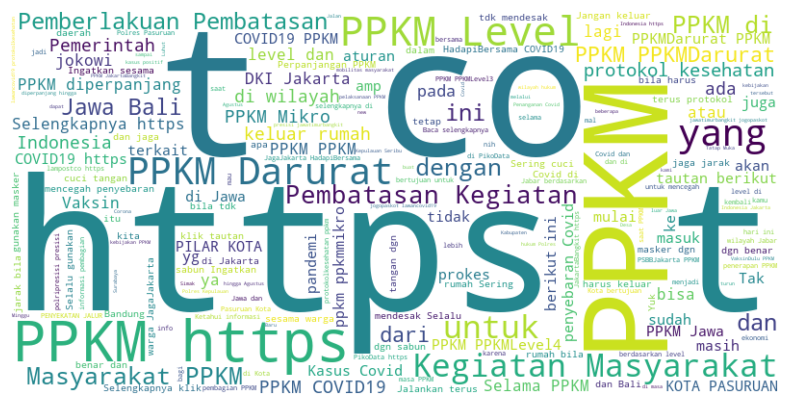

In [18]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text = " ".join(undersampled_sen_1['Tweet'])

# Membuat objek WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Menampilkan wordcloud menggunakan matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

kata-kata yang paling banyak muncul pada sentimen netral selain link ialah nama daerah , dan juga banyaknya penggunaan kata PPKM menunjukkan bahwa kebanyakan orang-orang dengan sentimen netral lebih banyak membicarakan tentang perkembangan di daerahnya masing-masing tanpa adanya kalimat optimis maupun pesimis, hanya pure informasi

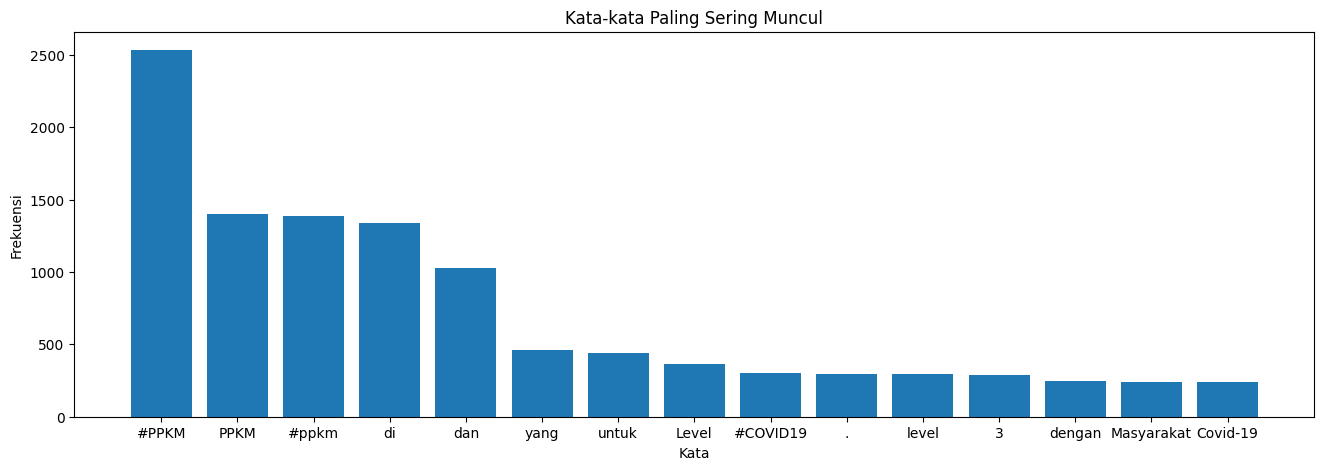

In [19]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text = " ".join(undersampled_sen_1['Tweet'])
words = text.split()  # Memisahkan teks menjadi kata-kata
# Hitung frekuensi kemunculan setiap kata
word_freq = Counter(words)

# Ambil N kata paling sering muncul
N = 15
most_common_words = word_freq.most_common(N)

# Buat plot untuk menampilkan kata-kata paling sering muncul
plt.figure(figsize=(16, 5))
plt.bar(*zip(*most_common_words))
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Kata-kata Paling Sering Muncul')
plt.show()

kata yang paling sering muncul pada sentimen netral ialah :

• Tagar yang merepresentasikan topik yang dibicarakan oleh user

• ada juga penggunaan PPKM diluar tagar, dan juga ada kata level , masyarakat. Biasanya yang menggunakan kata-kata seperti ini ialah portal berita ataupun instansi pemerintah yang menginformasikan perkembangan dari kebijakan nya

In [20]:
undersampled_sen_1.head(5)

,Date,User,Tweet,sentiment
568,2022-02-13 07:43:50+00:00,PemKabTangerang,Bupati Zaki didampingi Kapolres Tangerang Sela...,1
18608,2021-07-06 08:53:20+00:00,OnlineshopMu,Peci Muhammadiyah Gold Classic: Songkok AC Bor...,1
22055,2021-02-12 06:19:53+00:00,PolresTts,"Sambangi aparat Desa Muna, Polri ajak berperan...",1
19614,2021-07-04 06:00:09+00:00,VIVAcoid,"Koordinator PPKM Darurat Jawa dan Bali, Luhut ...",1
23397,2021-01-11 08:44:22+00:00,murianewscom,"PPKM, Kudus Tutup 107 Tempat Wisata Selama Dua...",1


## WordCloud Negatif

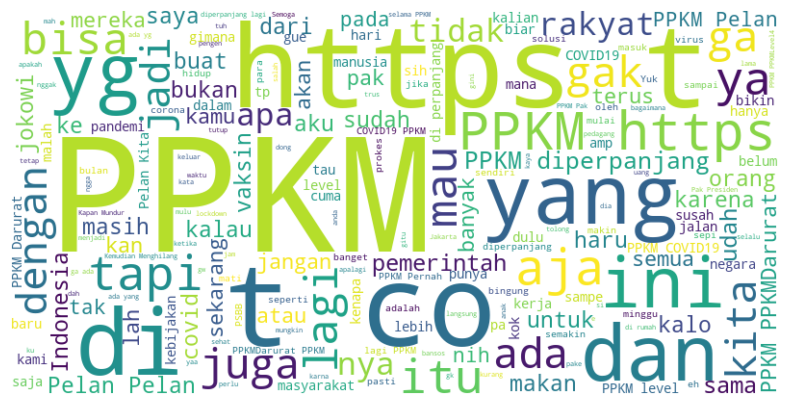

In [21]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text = " ".join(sen_2['Tweet'])

# Membuat objek WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Menampilkan wordcloud menggunakan matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

pada sentimen negatif, kata-kata negasi banyak muncul dan juga ada kata "Pelan Pelan" dimana pada saat itu banyak orang yang protes terhadap kebijakan pemerintah melakukan lockdown memplesetkan PPKM menjadi "PelanPelanKitaMeninggal" dikarenakan aturan yang ketat dan jangka waktu yang lama

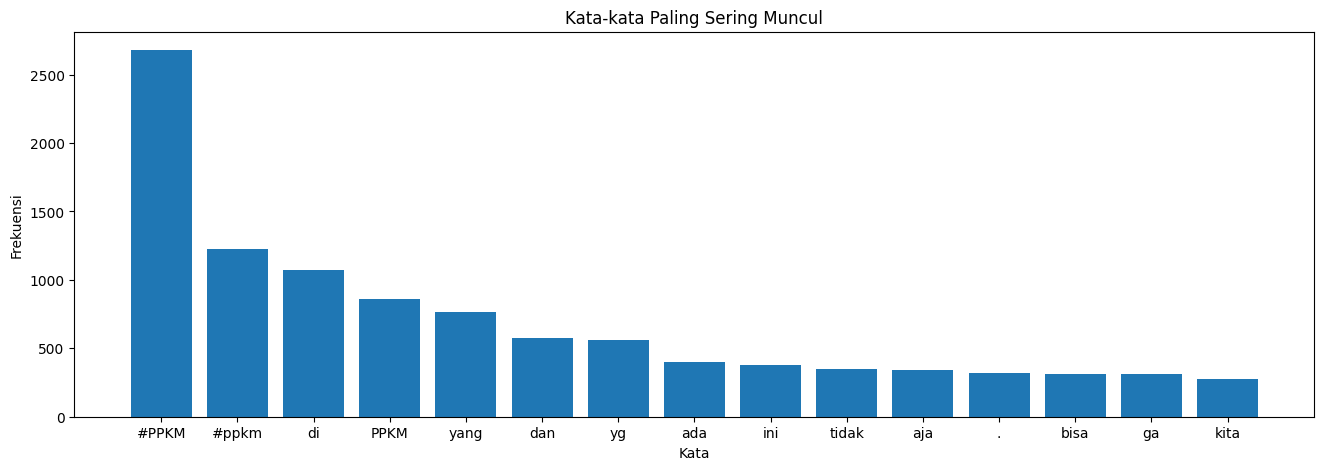

In [22]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text = " ".join(sen_2['Tweet'])
words = text.split()  # Memisahkan teks menjadi kata-kata
# Hitung frekuensi kemunculan setiap kata
word_freq = Counter(words)

# Ambil N kata paling sering muncul
N = 15
most_common_words = word_freq.most_common(N)

# Buat plot untuk menampilkan kata-kata paling sering muncul
plt.figure(figsize=(16, 5))
plt.bar(*zip(*most_common_words))
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Kata-kata Paling Sering Muncul')
plt.show()

sama seperti sebelumnya, penggunaan tagar merupakan kata yang paling sering muncul sesuai dengan topiknya, perbedaaan nya ialah pada sentimen negatif terdapat beberapa kata negasi yang sering digunakan seperti "tidak" , "ga" serta juga banyaknya kata preposisi

# Pre-Processing ( Cleaning Text )

In [23]:
stpwds_id = list(set(stopwords.words('indonesian')))
factory = StemmerFactory()
stemmer = factory.create_stemmer() # Membuat variable yang berisikan stopword bahasa indonesia

untuk tahap preprocessing saya menggunakan stopword bahasa indonesia dari library pysastrawi. dimana fungsi stopword adalah menghilangkan kata-kata yang dianggap umum, tidak informatif, dan sering muncul dalam teks, tetapi tidak memberikan makna khusus dalam analisis.

In [24]:
"tidak" in stpwds_id

True

In [25]:
"nya" in stpwds_id

False

In [26]:
len(stpwds_id) # Mengecek banyaknya stopword yang ada

757

In [27]:
stpwds_id.remove('tidak') # menghapus kata tidak dari stopword

In [28]:
len(stpwds_id) # mengecek banyaknya stopword setelah kata tidak dikeluarkan

756

In [29]:
stpwds_id.append('nya') # Menambahkan kata nya

In [30]:
len(stpwds_id) # Mengecek banyaknya stopword yang ada

757

setelah saya mengecek isi dari stopword yang ada. saya menemukan kata "tidak" didalamnya. menurut saya kata negasi disini penting sehingga saya mengeluarkannya dari stopword dan saya juga menambahkan kata "nya" ke dalam stopword dikarenakan tidak ada di dalam stopword

In [31]:
kamus = { "@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin","gak" : "tidak","moga":"semoga","max":"Maksimal","ampe":"sampai","amp":"sampai" }

disini saya juga membuat sebuah variable berisikan kamus word formalization yang fungsinya adalah digunakan untuk mengubah kata-kata dalam teks menjadi bentuk formal atau standar.

ref : [here](https://github.com/louisowen6/NLP_bahasa_resources/blob/master/combined_slang_words.txt)

In [2]:
def formalize_words(text, word_formalization_dict):
    # Membuat regular expression berdasarkan key pada dictionary
    pattern = re.compile(r'\b(' + '|'.join(kamus.keys()) + r')\b')

    # Fungsi penggantian kata yang mengambil match dari regular expression dan menggantikan dengan value dalam dictionary
    def replace_words(match):
        return kamus[match.group(0)]

    # Menggunakan fungsi sub dari re untuk melakukan penggantian kata berdasarkan regular expression
    formalized_text = pattern.sub(replace_words, text)

    return formalized_text

In [4]:
def text_proses(teks):
  # Mengubah Teks ke Lowercase
  teks = teks.lower()

  # Menghilangkan Mention
  teks = re.sub("@[A-Za-z0-9_]+", " ", teks)

  # Menghilangkan Hashtag
  teks = re.sub("#[A-Za-z0-9_]+", " ", teks)

  # Menghilangkan \n
  teks = re.sub(r"\\n", " ",teks)

  # Menghilangkan Whitespace
  teks = teks.strip()

  # Menghilangkan Link
  teks = re.sub(r"http\S+", " ", teks)
  teks = re.sub(r"www.\S+", " ", teks)

  # Menghilangkan yang Bukan Huruf seperti Emoji, Simbol Matematika (seperti μ), dst
  teks = re.sub("[^A-Za-z\s']", " ", teks)

  # Menghilangkan RT
  teks = re.sub("rt", " ",teks)

  # Menghilangkan kata yang berjumlah kurang dari 3 karakter
  teks = re.sub(r'\b\w{1,2}\b', '', teks)

  # Menghilangkan imbuhan kata tidak penting ( duh gustiiiii >> duh gusti )
  teks = re.sub(r'(\w)\1{2,}', r'\1', teks)

  # menyamaratakan kata-kata tertawa yang artinya mirip ( hahahahahaha hihihihihi hohoho aokwoak wkwkwkwk >> haha haha haha haha haha )
  teks = re.sub(r'\b(wk+|aok+|ha+h[aeiou]+|hi+h[aeiou]+|ho+h[aeiou]+)\b', 'haha', teks)

  # Melakukan Tokenisasi
  tokens = word_tokenize(teks)

  # Menghilangkan Stopwords
  teks = ' '.join([word for word in tokens if word not in stpwds_id])

  # Word formalization
  teks = formalize_words(teks, formalize_words)
 
  # Melakukan Stemming
  teks = stemmer.stem(teks)


  return teks

teks yang telah melalui proses cleaning kemudian saya masukkan ke dalam 1 kolom baru bernama processed tweet

In [34]:
df_new['processed_tweet'] = df_new['Tweet'].apply(lambda x: text_proses(x))
df_new

,Date,User,Tweet,sentiment,processed_tweet
0,2021-12-01 05:25:23+00:00,MFAnolyte,Saya menjual Anolyte AG Jerigen 5... seharga R...,1,jual anolyte jerigen harga dapat shopee kirim ...
1,2021-07-04 00:42:29+00:00,Andri_5151,"daripada gabut mikirin copat copit terus, yuk ...",2,gabut mikirin copat copit yuk main singkat ppk...
2,2021-08-30 15:26:44+00:00,Kidut_Jr,#PPKM #PelanPelanKitaMeninggal #PerutPerihKura...,1,
3,2021-07-20 07:36:07+00:00,InfoJogja1,Keputusan Pelik PPMK Diperpanjang atau Tidak??...,1,putus pelik ppmk panjang tidak tidak mudah put...
4,2021-08-13 04:27:05+00:00,temanerzaldiro1,Para nakes garda terdepan perjuangan melawan C...,0,nakes garda depan juang lawan covid energi butuh
...,...,...,...,...,...
9913,2021-07-04 19:01:05+00:00,mifreakmans21,"Nyari kerja itu mudah, cuma yang agak sulit me...",0,cari kerja mudah sulit biasa
9914,2021-07-19 07:23:36+00:00,alineadotid,"Juru Bicara Vaksinasi Kemenkes, Siti Nadia Tar...",0,juru bicara vaksinasi kemenkes siti nadia tarm...
9915,2021-07-14 09:03:49+00:00,TaylorFineGoods,Selama masa PPKM gini kalian coba hobi baru ga...,0,ppkm gin coba hobi tidak sih kalau scarlett co...
9916,2021-01-11 07:43:48+00:00,murianewscom,Jam Operasional Pasar di Kudus Tetap Sama Sela...,1,jam operasional pasar kudus ppkm prokes ketat


In [35]:
clean_data = df_new[df_new['processed_tweet'].str.strip() != ""]
clean_data

,Date,User,Tweet,sentiment,processed_tweet
0,2021-12-01 05:25:23+00:00,MFAnolyte,Saya menjual Anolyte AG Jerigen 5... seharga R...,1,jual anolyte jerigen harga dapat shopee kirim ...
1,2021-07-04 00:42:29+00:00,Andri_5151,"daripada gabut mikirin copat copit terus, yuk ...",2,gabut mikirin copat copit yuk main singkat ppk...
3,2021-07-20 07:36:07+00:00,InfoJogja1,Keputusan Pelik PPMK Diperpanjang atau Tidak??...,1,putus pelik ppmk panjang tidak tidak mudah put...
4,2021-08-13 04:27:05+00:00,temanerzaldiro1,Para nakes garda terdepan perjuangan melawan C...,0,nakes garda depan juang lawan covid energi butuh
6,2021-08-02 12:30:01+00:00,starvingstudios,EXTENDED! #ppkm https://t.co/GrvRpEj3g0,1,extended
...,...,...,...,...,...
9913,2021-07-04 19:01:05+00:00,mifreakmans21,"Nyari kerja itu mudah, cuma yang agak sulit me...",0,cari kerja mudah sulit biasa
9914,2021-07-19 07:23:36+00:00,alineadotid,"Juru Bicara Vaksinasi Kemenkes, Siti Nadia Tar...",0,juru bicara vaksinasi kemenkes siti nadia tarm...
9915,2021-07-14 09:03:49+00:00,TaylorFineGoods,Selama masa PPKM gini kalian coba hobi baru ga...,0,ppkm gin coba hobi tidak sih kalau scarlett co...
9916,2021-01-11 07:43:48+00:00,murianewscom,Jam Operasional Pasar di Kudus Tetap Sama Sela...,1,jam operasional pasar kudus ppkm prokes ketat


dikarenakan proses cleaning ada baris-baris yang dihapus dikarenakan tweet nya menjadi kosong. contohnya seperti tweet yang isinya merupakan Tagar semua ataupun isi tweet nya merupakan semua yang ada di stopword dan sebagainya

# EDA setelah Preprocessing

In [36]:
sen0clean = clean_data[clean_data['sentiment'] == 0] # Memisahkan tweet dengan sentimen 0 ( Positif )
sen1clean = clean_data[clean_data['sentiment'] == 1] # Memisahkan tweet dengan sentimen 1 ( Netral )
sen2clean = clean_data[clean_data['sentiment'] == 2] # Memisahkan tweet dengan sentimen 2 ( Negatif )

## Wordcloud Keseluruhan

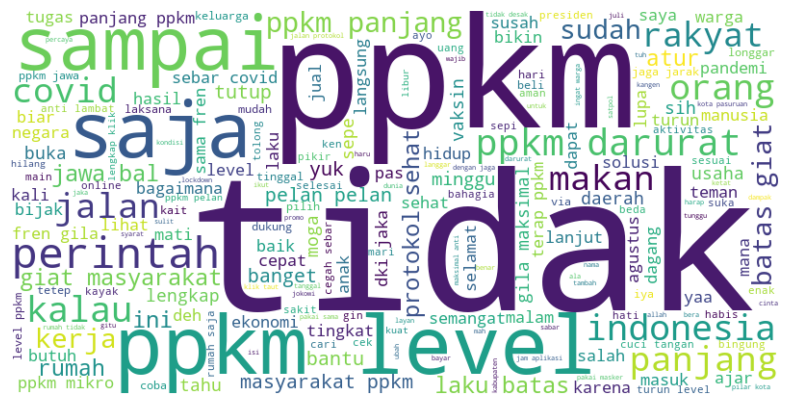

In [37]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text = " ".join(clean_data['processed_tweet'])

# Membuat objek WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Menampilkan wordcloud menggunakan matplotlib
plt.figure(figsize=(16, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

setelah melalui proses cleaning, kata-kata seperti tagar, link dan kata preposisi telah dihilangkan

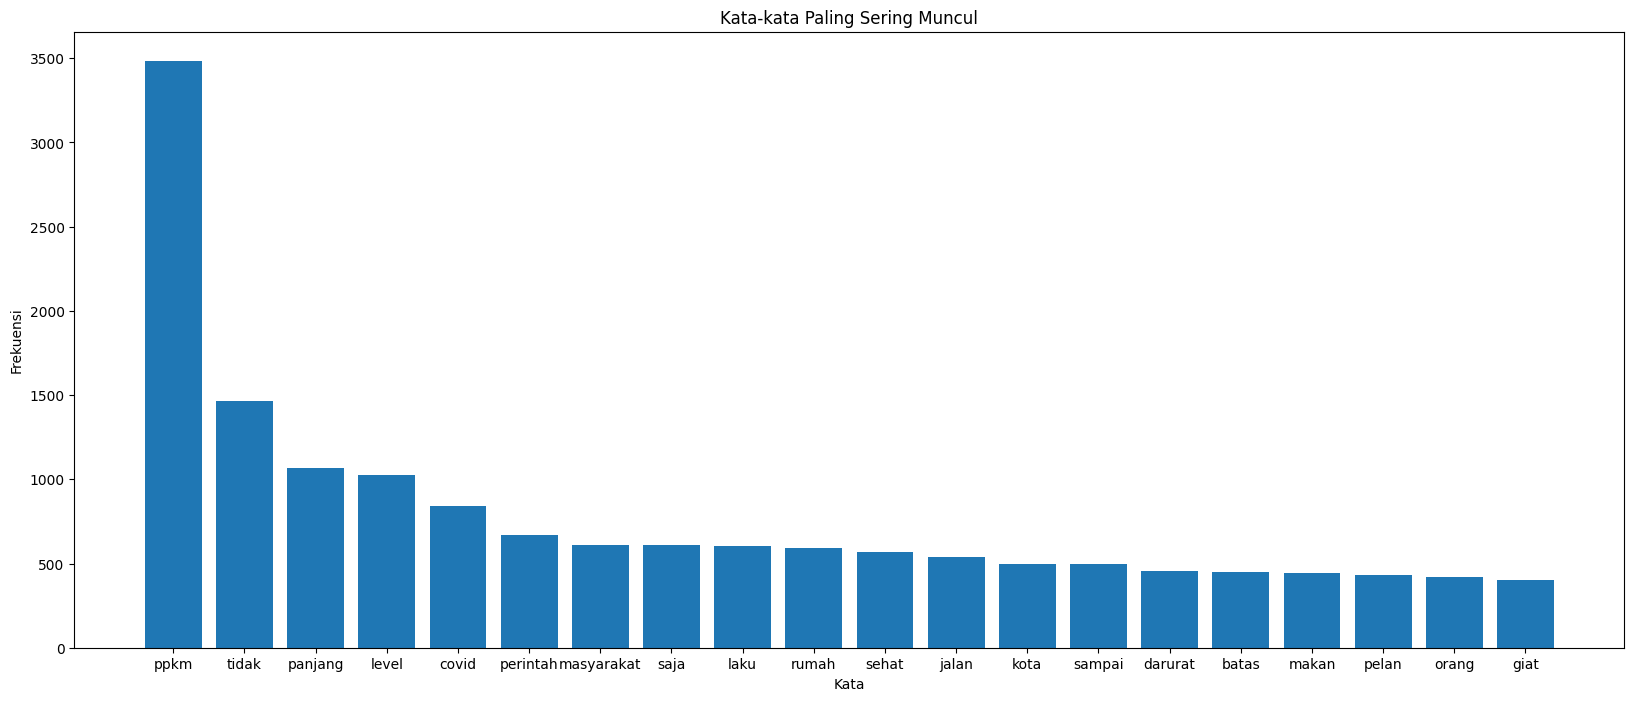

In [38]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text = " ".join(clean_data['processed_tweet'])
words = text.split()  # Memisahkan teks menjadi kata-kata
# Hitung frekuensi kemunculan setiap kata
word_freq = Counter(words)

# Ambil N kata paling sering muncul
N = 20
most_common_words = word_freq.most_common(N)

# Buat plot untuk menampilkan kata-kata paling sering muncul
plt.figure(figsize=(20, 8))
plt.bar(*zip(*most_common_words))
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Kata-kata Paling Sering Muncul')
plt.show()

banyak kata baru yang menjadi 15 kata paling sering muncul secara keseluruhan setelah teks dibersihkan

## Wordcloud Positif

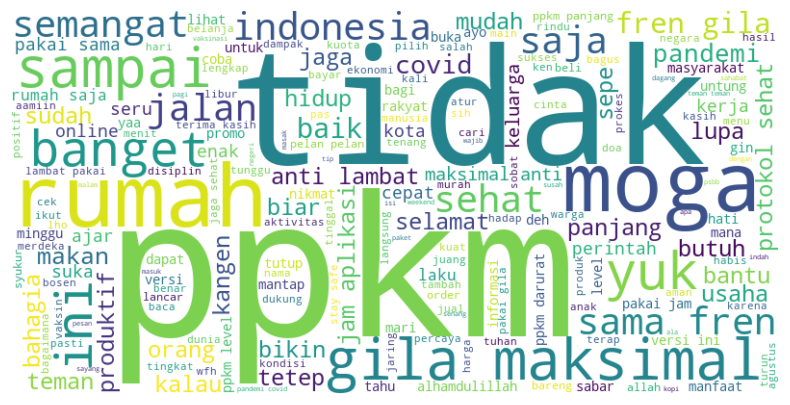

In [39]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text = " ".join(sen0clean['processed_tweet'])

# Membuat objek WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Menampilkan wordcloud menggunakan matplotlib
plt.figure(figsize=(16, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

wordcloud pada sentimen positif juga telah bersih dari link dan kata preposisi setelah pembersihan. akan tetapi ada kata tidak yang merujuk pada negasi. untuk itu saya akan melihat seperti apa contoh kalimat yang memiliki kata tidak dan memiliki sentimen positif

In [40]:
pd.set_option('display.max_colwidth', None)
sen0clean[sen0clean['processed_tweet'].str.contains('tidak')].head(5)

,Date,User,Tweet,sentiment,processed_tweet
92,2021-07-24 02:20:37+00:00,accurateid,"PPKM, PPKM: Ketat, PPKM Age of Ultron, PPKM Darurat Infinity War, yang penting, bisnis kita nggak boleh tunggang langgang dong.\n\nAccurate dapat membantu mengelola keuangan dan memudahkan perencanaan bisnis.⁠\n\n#ppkm #tipsbisnis #bisnisjadimudah #accurate #accurateid https://t.co/0iDJRM38az",0,ppkm ppkm ketat ppkm age ultron ppkm darurat infinity war bisnis tidak tunggang langgang accurate bantu kelola uang mudah rencana bisnis
113,2021-07-26 09:12:58+00:00,DhonyFirmansyah,"Makan pas #PPKM cuma 20 menit, gpp tenang. Bawa piring, keluar pintu warteg, masuk lagi, Anda dapat 20 menit waktu tambahan hehe.",0,makan pas menit tidak apa tenang bawa piring pintu masuk menit tambah he
154,2021-07-10 01:10:37+00:00,bbpsik_jogja,Sudah weekend lagi .. tahan yaa untuk tidak keluar rumah dulu karena PPKM Darurat masih berlangsung 👌\n\nSo stay safe and healthy\n\n📷 Indah Yuniarsih\n\n.\n.\n#kementerianlhk\n#bli_klhk\n#biotifor_jogja\n#weekenddirumah\n#ppkm\n#kayuputih\n#pulai https://t.co/hNqigTJRDN,0,weekend tahan yaa tidak rumah ppkm darurat stay safe and healthy indah yuniarsih
176,2021-07-08 05:00:00+00:00,samcofarma,"Kalo kamu bahagia, secara otomatis tubuh kamu membangun benteng yang kuat agar tidak mudah terserang penyakit.⁣⁣\n.\n.\n#Samco #samcofarma #samcorbex #samcemin #vitaminc #healthylife #healthy #healthylifestyle #HealthyEating #healthyliving #sehat #ppkm #ppkmdarurat ⁣⁣ https://t.co/eWuuHF6TXa",0,kalau bahagia otomatis tubuh bangun benteng kuat tidak mudah serang sakit
264,2021-07-09 02:20:02+00:00,harisubagya,💐💐💪💪Siapa yg mau NEKADDDDDD ikut PPKM TRAINER? https://t.co/FUXEbV1Vm7 YG SERIUS BANGET. Kalau tidak saya rugi\n#ppkm trainer,0,nekad ppkm trainer serius banget tidak rugi trainer


setelah melihat 5 contoh kalimat yang memiliki kata "tidak" serta sentimen positif, kata "TIDAK" disini merupakan imbuhan yang digunakan untuk memperkuat kalimat positif

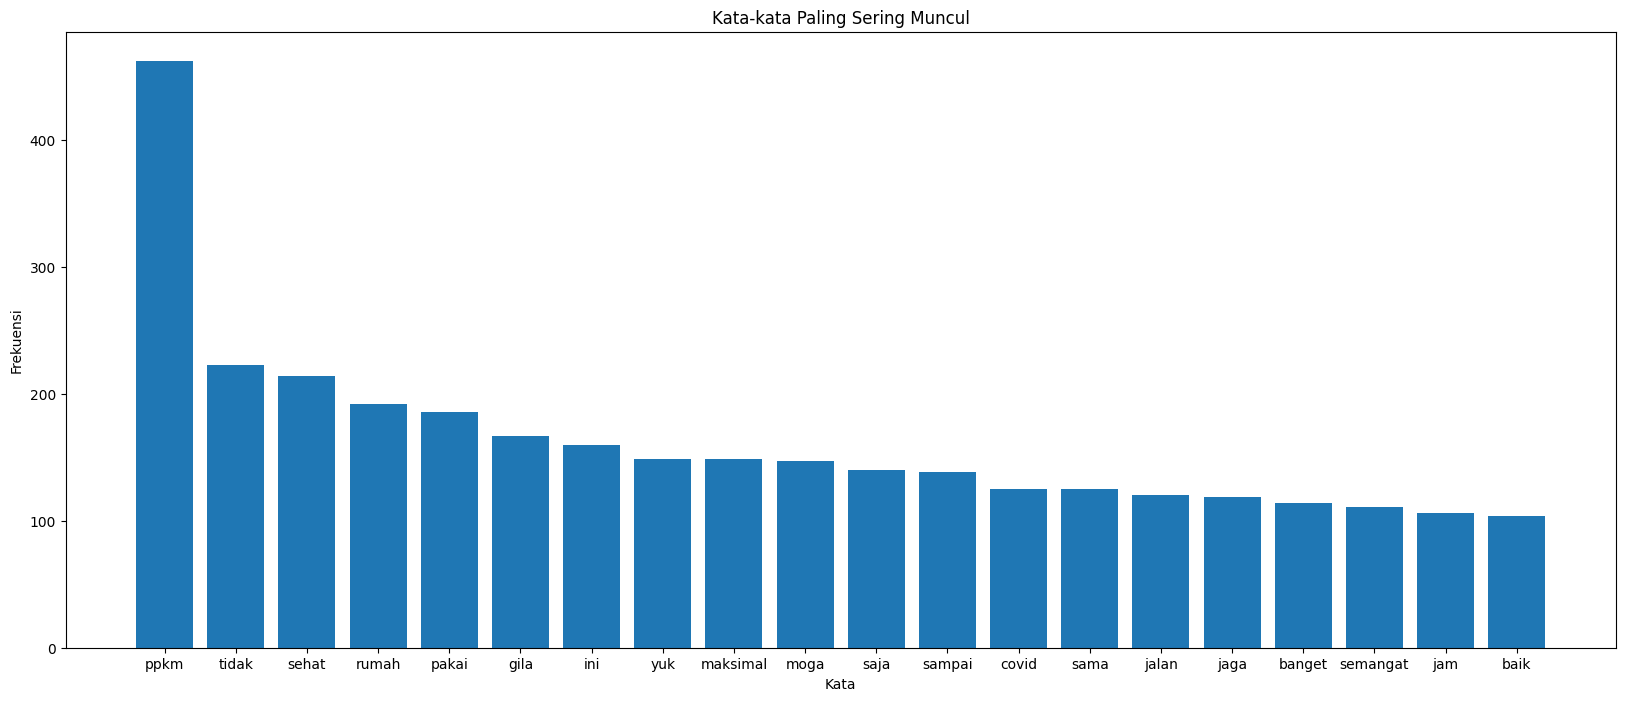

In [41]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text = " ".join(sen0clean['processed_tweet'])
words = text.split()  # Memisahkan teks menjadi kata-kata
# Hitung frekuensi kemunculan setiap kata
word_freq = Counter(words)

# Ambil N kata paling sering muncul
N = 20
most_common_words = word_freq.most_common(N)

# Buat plot untuk menampilkan kata-kata paling sering muncul
plt.figure(figsize=(20, 8))
plt.bar(*zip(*most_common_words))
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Kata-kata Paling Sering Muncul')
plt.show()

kata yang paling sering muncul pada sentimen positif disini merupakan kata-kata yang biasanya ada pada kalimat ajakan.tetapi ada kata gila disini. saya ingin coba melihat apa isi dari tweet yang mengandung kata "gila" pada sentimen positif

In [42]:
sen0clean[sen0clean['processed_tweet'].str.contains('gila')].head(5)

,Date,User,Tweet,sentiment,processed_tweet
78,2021-09-23 08:20:36+00:00,Tripolicious,#ppkm seru bareng Smartfren GOKIL MAX dari @smartfrenworld \n#KuyBisa\n#IniBaruGokil\n#RejekiWow #TemanBukaPeluangmu #KuotaSultanHargaTeman\n\nhttps://t.co/F0NPLTQNKI,0,seru bareng sama fren gila maksimal
131,2021-07-19 13:34:23+00:00,Riezhaaulia,#PPKM versiku nih #dirumahaja \nUntungnya ada Smartfren GOKIL MAX!! @smartfrenworld \n#IniBaruGokil #KuyBisa #RejekiWOW \n\nhttps://t.co/V1IJYZpCnM,0,versi ini untung sama fren gila maksimal
193,2021-07-20 14:49:03+00:00,jhosierlinda,Ppkm versi aku nih lebih banyak bikin kegiatan positif yang GOKIL bareng smartfren \n\n#ppkm #KuyBisa #IniBaruGokil \n#Rejekiwow\n@smartfrenworld https://t.co/tAlQncoAlY,0,ppkm versi ini bikin giat positif gila bareng sama fren
317,2021-08-11 08:27:07+00:00,kangkungijoo,"#PPKM versi aku,belajar online sambil sosmedan tapi ga ngebosenin karena aku pakai smartfren Gokil MAX anti lelet dan bisa dipakai 24jam di semua aplikasi \n@smartfrenworld \n#KuyBisa #IniBaruGokil \n#Rejekiwow #RejekiDepanMata \n\nhttps://t.co/1yLwSehUnF",0,versi ajar online sosmedan ngebosenin pakai sama fren gila maksimal anti lambat pakai jam aplikasi
327,2021-09-24 03:08:17+00:00,yulia14_2,Lancar luncur internetan selama #PPKM ini baru beneran Gokilll \n\n@smartfrenworld\n#KuyBisa \n#IniBaruGokil \n#Rejekiwow #TemanBukaPeluangmu #KuotaSultanHargaTeman https://t.co/J3203PxwG0,0,lancar luncur internetan beneran gila


ternyata penggunaan kata gila disini merupakan hasil dari stopword yang mengubah kata "gokil" menjadi gila. dan disini kata gokil / gila yang digunakan ialah kalimat promosi dari provider Internet Smartfren

## Wordcloud Netral

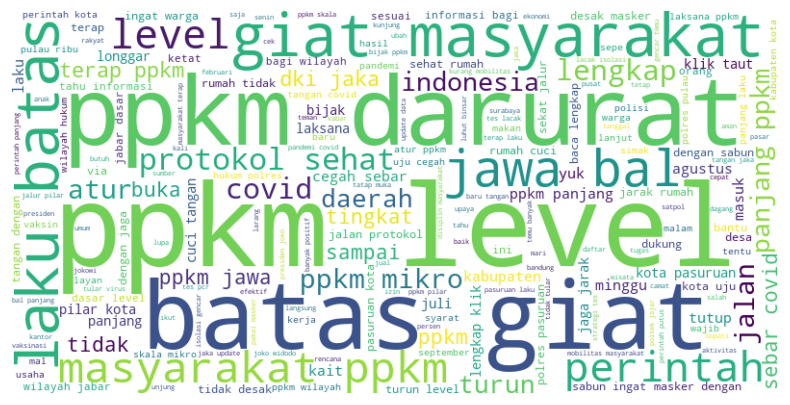

In [43]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text = " ".join(sen1clean['processed_tweet'])

# Membuat objek WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Menampilkan wordcloud menggunakan matplotlib
plt.figure(figsize=(16, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

wordcloud dengan sentimen netral juga telah bersih dari link, tetapi ada kata-kata yang tidak saya pahami seperti jaka, dan bal

In [44]:
sen1clean[sen1clean['processed_tweet'].str.contains('jaka')].head(5)

,Date,User,Tweet,sentiment,processed_tweet
0,2021-12-01 05:25:23+00:00,MFAnolyte,Saya menjual Anolyte AG Jerigen 5... seharga Rp250.000. Dapatkan di Shopee sekarang! https://t.co/xU24PFAqCi #ShopeeID\n\n🚚Kirim dari:\nJln. Bintaro Raya TANAH KUSIR\nJAKARTA SELATAN🌍\n\n💥POTENSI BEBAS ONGKIR🚚🚚\n#Jakarta #Bogor #Depok #Tangerang #Bekasi #Banten #PPKM #Virus #Nataru https://t.co/92a5dtBR3J,1,jual anolyte jerigen harga dapat shopee kirim jalan bintaro raya tanah kusir jaka selatan potensi bebas ongkos kirim
46,2021-09-16 09:20:13+00:00,FebrianRentalm1,PUSAT SEWA MOBIL (DRIVER+BBM) 💯% TERMURAH SE-JAKARTA✌😁\n#sewamobiljakarta #liburankeluarga \n#rentalmobiljakarta #wisatajakarta #wisatabandung #sewahiacejakarta #sewahiacejakartaselatan #sewaalphardjakarta #keluarga #Jakarta #balitour #bandungtravel\n#travel #sewamobil #PPKM https://t.co/Lp1wnxqx1d,1,pusat sewa mobil driver bbm murah jaka
60,2021-10-26 10:15:58+00:00,pikiran_rakyat,"Tak Ada RT Zona Merah dan Orange di Jakarta, Wagub DKI Riza Patria Apresiasi Kekompakan Warga\n\nhttps://t.co/2IyC6jQLpp \n\n#wagub #wakil #gubernur #ahmadrizapatria #rizapatria #dki #jakarta #apresiasi #kompak #warga #masyarakat #prokes #ppkm #covid19 #indonesia #nasional #prmn",1,zona merah orange jaka wagub dki riza patria apresiasi kompak warga
79,2021-01-09 03:49:01+00:00,mnctrijaya,Bagaimana penerapan aktivitas terkini di Kota Yogjakarta untuk memutuskan rantai virus covid-19? #PPKM #JawaBali #Covid19\n\nSaksikan siaran langsungnya dengan klik link berikut ini https://t.co/nClsunio5s https://t.co/x4dr8SvARW,1,terap aktivitas kini kota yogjaka putus rantai virus covid saksi siar langsung klik link
101,2021-03-08 10:22:28+00:00,validnewsid,"Gubernur Provinsi DKI Jakarta, Anies Baswedan, terus mengimbau seluruh warga untuk tetap berada di rumah serta menahan diri untuk berpergian keluar kota terutama saat libur panjang akhir pekan.\n\n#Validnews #PPKM \n\nhttps://t.co/AjjQHo2UB0",1,gubernur provinsi dki jaka anies baswedan imbau warga rumah tahan pergi kota libur pekan


ternyata jaka adalah hasil cleaning dari kata jakarta

In [45]:
sen1clean[sen1clean['processed_tweet'].str.contains('bal')].head(5)

,Date,User,Tweet,sentiment,processed_tweet
68,2021-07-19 07:17:39+00:00,alineadotid,"Juru Bicara Vaksinasi Kemenkes, Siti Nadia Tarmizi : Kalau kita bicara tempat perawatan isolasi, ini bisa dilakukan isolasi masyarakat. Misalnya kita tahu kemarin pada arus mudik dan balik banyak Desa yang menggunakan balai Desanya..\n#PPKM #PPKMdarurat #Kemenkes",1,juru bicara vaksinasi kemenkes siti nadia tarmizi bicara awat isolasi isolasi masyarakat kemarin arus mudik desa balai desa
124,2021-11-02 04:00:00+00:00,PemKabTangerang,"Kab. Tangerang masuk PPKM level 1. Berdasarkan Instruksi Mendagri No.57/2021 tentang PPKM level 3, level 2, level 1 Covid-19 di Wilayah Jawa dan Bali. Masyarakat diimbau tetap terapkan prokes dan lakukan vaksin bagi yang belum.\n\n#KabupatenTangerangLevel1 #PPKM #TangerangBangkit https://t.co/CokkweSH7g",1,kabupaten tangerang masuk ppkm level dasar instruksi mendagri ppkm level level level covid wilayah jawa bal masyarakat imbau terap prokes laku vaksin
215,2021-11-08 09:49:38+00:00,Beritasatu,PPKM terus memberikan dampak positif pada pengendalian Covid-19 di Jawa-Bali.\nSelengkapnya: 👇 #PPKM\nhttps://t.co/eovjiWCtMd,1,ppkm dampak positif kendali covid jawa bal lengkap
244,2021-11-16 12:27:45+00:00,lampungpost_,"Evaluasi penerapan PPKM pada wilayah Jawa-Bali dan Luar Jawa-Bali terus dilakukan setiap minggu, meskipun periode PPKM kali ini masih akan berlanjut hingga 22 November 2021.\n#ppkm #ppkmjawabali #airlanggahartarto #lampostco\nhttps://t.co/Ae1Z1ydYlj",1,evaluasi terap ppkm wilayah jawa bal jawa bal minggu periode ppkm kali lanjut november
245,2021-08-10 06:49:49+00:00,kaspito,Yang juga perlu dipikirkan Pemerintah Pusat dan Daerah di masa #PPKM ini ialah gimana cara #mempercepat penyaluran #VaksinasiCOVID19 di Jawa-Bali agar segera tercipta #HerdImmunity. #PPKMEfektifTekanLajuKovid @KemenkesRI @luhut_binsar @jokowi https://t.co/0LBxhsEoha,1,pikir perintah pusat daerah bagaimana salur jawa bal cipta


sedangkan bal ialah hasil cleaning dari kata balai & bali

kedua kata ini merupakan hasil stemming dari nama daerah

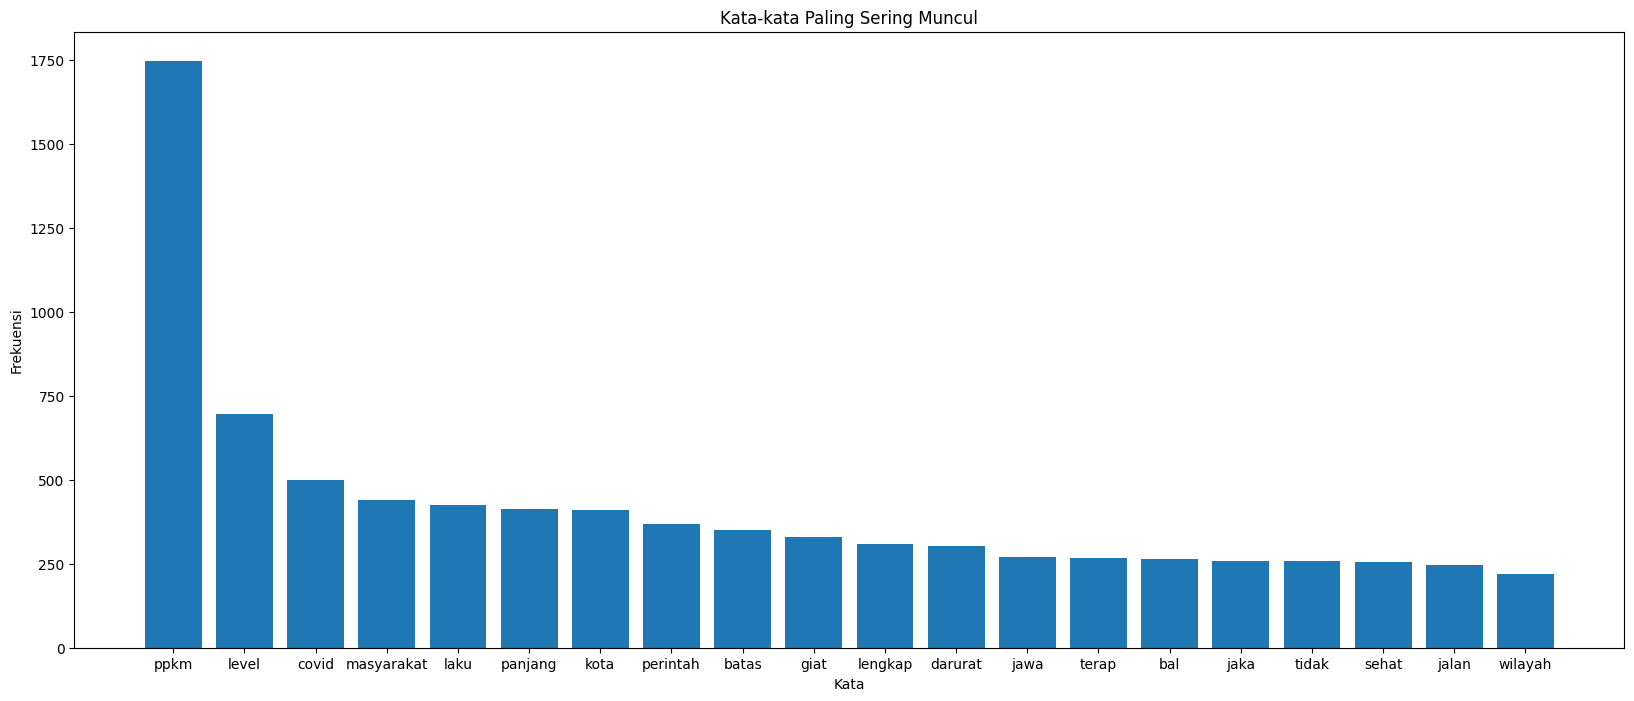

In [46]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text = " ".join(sen1clean['processed_tweet'])
words = text.split()  # Memisahkan teks menjadi kata-kata
# Hitung frekuensi kemunculan setiap kata
word_freq = Counter(words)

# Ambil N kata paling sering muncul
N = 20
most_common_words = word_freq.most_common(N)

# Buat plot untuk menampilkan kata-kata paling sering muncul
plt.figure(figsize=(20, 8))
plt.bar(*zip(*most_common_words))
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Kata-kata Paling Sering Muncul')
plt.show()

## Wordcloud Negatif

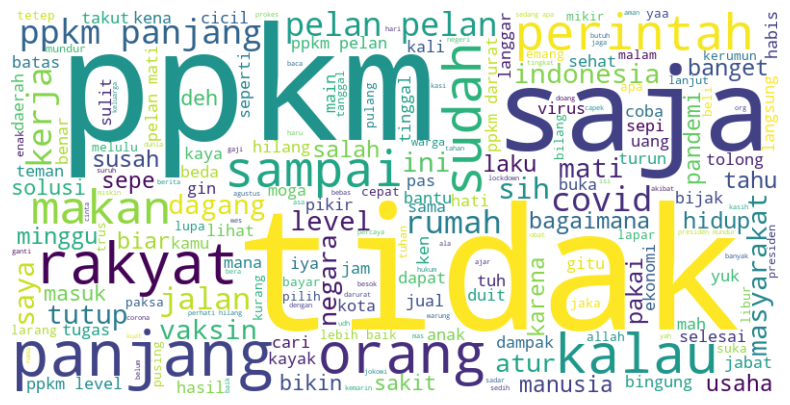

In [47]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text = " ".join(sen2clean['processed_tweet'])

# Membuat objek WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Menampilkan wordcloud menggunakan matplotlib
plt.figure(figsize=(16, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

sama seperti 3 wordcloud sebelumnya setelah dilakukan cleaning, tidak ada lagi kata-kata yang berasal dari link

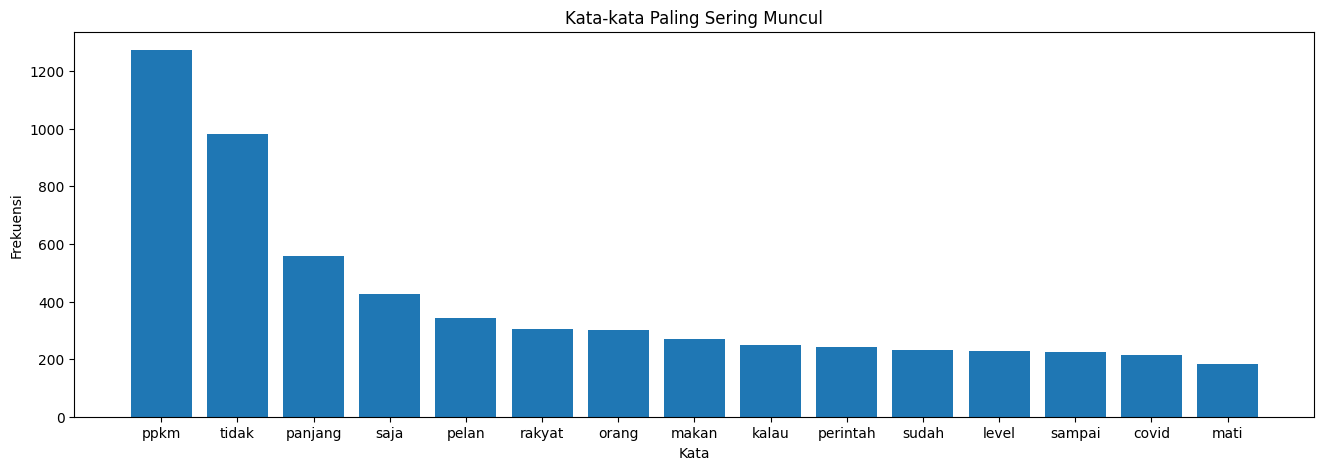

In [48]:
# Gabungkan semua teks dari DataFrame menjadi satu string
text = " ".join(sen2clean['processed_tweet'])
words = text.split()  # Memisahkan teks menjadi kata-kata
# Hitung frekuensi kemunculan setiap kata
word_freq = Counter(words)

# Ambil N kata paling sering muncul
N = 15
most_common_words = word_freq.most_common(N)

# Buat plot untuk menampilkan kata-kata paling sering muncul
plt.figure(figsize=(16, 5))
plt.bar(*zip(*most_common_words))
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Kata-kata Paling Sering Muncul')
plt.show()

# Model definition

## Splitting Train & test set

In [49]:
X_train, X_test, y_train, y_test = train_test_split(clean_data.processed_tweet,
                                                    clean_data.sentiment,
                                                    test_size=0.2,
                                                    random_state=9,
                                                    stratify=clean_data.sentiment)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (7591,)
Test Size  :  (1898,)


sebelum melakukan pemodelan saya memisahkan terlebih dahulu antara data train dengan data tes nya. Proses ini sangat penting untuk mengevaluasi sejauh mana model yang dibuat dapat digeneralisasi dan diterapkan pada data yang belum pernah dilihat sebelumnya

## Text Vectorization

setelah itu saya melakukan text vectorization yang gunanya ialah mengubah text yang berbentuk sting ke dalam bentuk vector dikarenakan komputer hanya dapat memproses data dalam bentuk angka

In [50]:
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<7591x10775 sparse matrix of type '<class 'numpy.int64'>'
	with 73324 stored elements in Compressed Sparse Row format>

In [51]:
jml_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print("Jumlah vocab : ", jml_vocab)
print("Panjang maksimum kalimat : ", max_sen_len, "kata")

Jumlah vocab :  10775
Panjang maksimum kalimat :  39 kata


In [52]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=jml_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,) # 1 dipakai karena saya akan menggunakan model sequential
                                       )

text_vectorization.adapt(X_train)

In [53]:
text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'ppkm',
 'tidak',
 'panjang',
 'level',
 'covid',
 'perintah',
 'saja',
 'masyarakat',
 'laku',
 'rumah',
 'sehat',
 'jalan',
 'kota',
 'sampai',
 'darurat',
 'makan',
 'pelan',
 'batas']

disini saya melihat 20 kata paling sering muncul dari data yang telah dilakukan vectorisasi, terdapat string kosong dan kata UNK pada data. kedua kata tersebut sudah pasti ada jika menggunakan text vectorization pada library tensorflow. string kosong disini berarti setiap kalimat atau dokumen yang kosong (tanpa kata) akan mewakili token kosong tersebut. sedangkan Token UNK (Unknown) digunakan untuk mewakili kata-kata yang tidak dikenal dalam proses vektorisasi. Ini berarti bahwa jika dalam dataset Anda ada kata-kata yang tidak termasuk dalam kamus (dictionary) yang digunakan oleh model, kata-kata tersebut akan direpresentasikan oleh token UNK.

In [54]:
embedding = Embedding(input_dim=jml_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len
                      )

selanjutnya saya melakukan embedding. Fungsi utama dari embedding adalah untuk mengubah kata-kata menjadi representasi vektor dengan dimensi yang lebih rendah, sehingga dapat digunakan sebagai input dari model. ini berarti jika saya melakukan embedding pada kata apple dan banana kemungkinan besar kedua kata tersebut memiliki vector yang mirip

In [55]:
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

## LSTM

In [56]:
# Model Training dengan Menggunakan LSTM

model = Sequential()
model.add(text_vectorization)
model.add(embedding)
model.add(LSTM(50, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(LSTM(25))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(3,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

model_lstm_hist_1 = model.fit(X_train,
                         y_train_ohe,
                         epochs=20,
                         validation_data=(X_test, y_test_ohe))

Epoch 1/20
238/238 [==============================] - 16s 48ms/step - loss: 0.8444 - accuracy: 0.6292 - val_loss: 0.9375 - val_accuracy: 0.5437
Epoch 2/20
238/238 [==============================] - 10s 42ms/step - loss: 0.4804 - accuracy: 0.8220 - val_loss: 0.7538 - val_accuracy: 0.6939
Epoch 3/20
238/238 [==============================] - 11s 47ms/step - loss: 0.3277 - accuracy: 0.8851 - val_loss: 0.9447 - val_accuracy: 0.7028
Epoch 4/20
238/238 [==============================] - 11s 46ms/step - loss: 0.2329 - accuracy: 0.9229 - val_loss: 1.0964 - val_accuracy: 0.6960
Epoch 5/20
238/238 [==============================] - 11s 45ms/step - loss: 0.1942 - accuracy: 0.9399 - val_loss: 1.2747 - val_accuracy: 0.6581
Epoch 6/20
238/238 [==============================] - 10s 43ms/step - loss: 0.1663 - accuracy: 0.9476 - val_loss: 1.1872 - val_accuracy: 0.6928
Epoch 7/20
238/238 [==============================] - 10s 43ms/step - loss: 0.1391 - accuracy: 0.9563 - val_loss: 1.1073 - val_accuracy:

<Axes: >

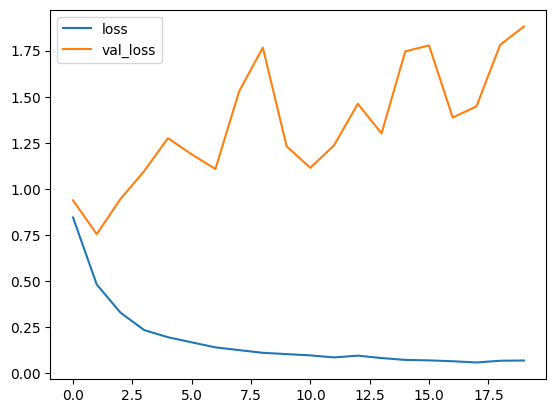

In [57]:
metrics = pd.DataFrame(model_lstm_hist_1.history)
metrics[['loss', 'val_loss']].plot()

pada model sequential ini mengalami overfit dimana pada data train model mempunyai loss yang mendekat 0 sedangkan loss nya terus naik. ini berarti bahwa model terlalu menghafal data train dan kurang baik menghadapi data yang belum pernah dilihat

## GRU

In [58]:
# Model Training dengan Menggunakan GRU

model = Sequential()
model.add(text_vectorization)
model.add(embedding)
model.add(GRU(50, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(GRU(25))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(3,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

model_GRU_hist_1 = model.fit(X_train,
                         y_train_ohe,
                         epochs=20,
                         validation_data=(X_test, y_test_ohe))

Epoch 1/20
238/238 [==============================] - 15s 45ms/step - loss: 0.7248 - accuracy: 0.6343 - val_loss: 1.0027 - val_accuracy: 0.6718
Epoch 2/20
238/238 [==============================] - 10s 42ms/step - loss: 0.1808 - accuracy: 0.9449 - val_loss: 1.2660 - val_accuracy: 0.6797
Epoch 3/20
238/238 [==============================] - 10s 41ms/step - loss: 0.1041 - accuracy: 0.9706 - val_loss: 1.4269 - val_accuracy: 0.6986
Epoch 4/20
238/238 [==============================] - 10s 41ms/step - loss: 0.1055 - accuracy: 0.9679 - val_loss: 1.2957 - val_accuracy: 0.7076
Epoch 5/20
238/238 [==============================] - 10s 41ms/step - loss: 0.0877 - accuracy: 0.9740 - val_loss: 1.7472 - val_accuracy: 0.6934
Epoch 6/20
238/238 [==============================] - 10s 41ms/step - loss: 0.0887 - accuracy: 0.9758 - val_loss: 1.3960 - val_accuracy: 0.6955
Epoch 7/20
238/238 [==============================] - 10s 41ms/step - loss: 0.0694 - accuracy: 0.9806 - val_loss: 1.4539 - val_accuracy:

<Axes: >

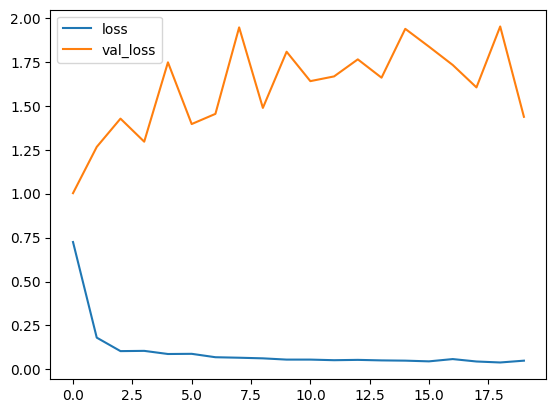

In [59]:
metrics = pd.DataFrame(model_GRU_hist_1.history)
metrics[['loss', 'val_loss']].plot()

sama dengan model sebelumnya, model ini juga mengalami overfit pada data train. hal ini juga tidak bagus

# Model Improvement

In [60]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-id-dim128-with-normalization/2",
                           input_shape=[], dtype=tf.string,)

untuk improvement disini saya menggunakan transfer learning pada layer embedding dari google news dikarenakan pada layer embedding ini data yang di train ada sebanyak 3 milyar kata sehingga kemungkinan besar performansi nya lebih baik daripada yang saya buat sendiri

In [77]:
tf.keras.utils.get_custom_objects()['hub_layer'] = hub_layer

## LSTM

In [78]:
# transfer learning pada step embedding lalu pemodelan menggunakan LSTM

model_lstm = Sequential()
model_lstm.add(hub_layer)
model_lstm.add(Reshape((1, 128)))  # Time_steps = 1
model_lstm.add(LSTM(32, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dense(3,activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

model_lstm_hist_2 = model_lstm.fit(X_train,
                         y_train_ohe,
                         epochs=20,
                         validation_data=(X_test, y_test_ohe))

Epoch 1/20
238/238 [==============================] - 5s 6ms/step - loss: 0.8754 - accuracy: 0.6114 - val_loss: 0.6610 - val_accuracy: 0.7513
Epoch 2/20
238/238 [==============================] - 1s 4ms/step - loss: 0.6518 - accuracy: 0.7386 - val_loss: 0.6053 - val_accuracy: 0.7666
Epoch 3/20
238/238 [==============================] - 1s 3ms/step - loss: 0.6225 - accuracy: 0.7469 - val_loss: 0.6027 - val_accuracy: 0.7650
Epoch 4/20
238/238 [==============================] - 1s 4ms/step - loss: 0.6109 - accuracy: 0.7542 - val_loss: 0.5945 - val_accuracy: 0.7677
Epoch 5/20
238/238 [==============================] - 1s 5ms/step - loss: 0.6040 - accuracy: 0.7575 - val_loss: 0.5925 - val_accuracy: 0.7661
Epoch 6/20
238/238 [==============================] - 1s 3ms/step - loss: 0.5982 - accuracy: 0.7569 - val_loss: 0.5941 - val_accuracy: 0.7655
Epoch 7/20
238/238 [==============================] - 1s 3ms/step - loss: 0.5944 - accuracy: 0.7624 - val_loss: 0.5892 - val_accuracy: 0.7692
Epoch 

<Axes: >

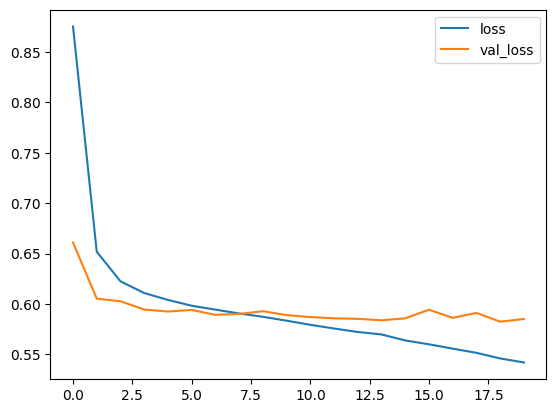

In [79]:
metrics = pd.DataFrame(model_lstm_hist_2.history)
metrics[['loss', 'val_loss']].plot()

pada model ini loss nya tidak se rendah model pertama tetapi cenderung stabil dan tidak mengalami overfit dikarenakan  loss pada data train dan validasi nya tidak berbeda jauh

## GRU

In [80]:
# transfer learning pada step embedding lalu pemodelan menggunakan GRU

model_GRU = Sequential()
model_GRU.add(hub_layer)
model_GRU.add(Reshape((1, 128)))  # Time_steps = 1
model_GRU.add(GRU(50, return_sequences=True))
model_GRU.add(GRU(25))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(3,activation='softmax'))

model_GRU.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

model_GRU_hist_2 = model_GRU.fit(X_train,
                         y_train_ohe,
                         epochs=20,
                         validation_data=(X_test, y_test_ohe))

Epoch 1/20
238/238 [==============================] - 5s 6ms/step - loss: 0.7973 - accuracy: 0.6750 - val_loss: 0.6161 - val_accuracy: 0.7619
Epoch 2/20
238/238 [==============================] - 1s 3ms/step - loss: 0.6366 - accuracy: 0.7467 - val_loss: 0.6020 - val_accuracy: 0.7645
Epoch 3/20
238/238 [==============================] - 1s 3ms/step - loss: 0.6217 - accuracy: 0.7508 - val_loss: 0.5956 - val_accuracy: 0.7729
Epoch 4/20
238/238 [==============================] - 1s 3ms/step - loss: 0.6146 - accuracy: 0.7558 - val_loss: 0.5965 - val_accuracy: 0.7576
Epoch 5/20
238/238 [==============================] - 1s 3ms/step - loss: 0.6105 - accuracy: 0.7552 - val_loss: 0.5935 - val_accuracy: 0.7719
Epoch 6/20
238/238 [==============================] - 1s 3ms/step - loss: 0.6062 - accuracy: 0.7544 - val_loss: 0.5941 - val_accuracy: 0.7582
Epoch 7/20
238/238 [==============================] - 1s 3ms/step - loss: 0.6022 - accuracy: 0.7618 - val_loss: 0.5920 - val_accuracy: 0.7661
Epoch 

<Axes: >

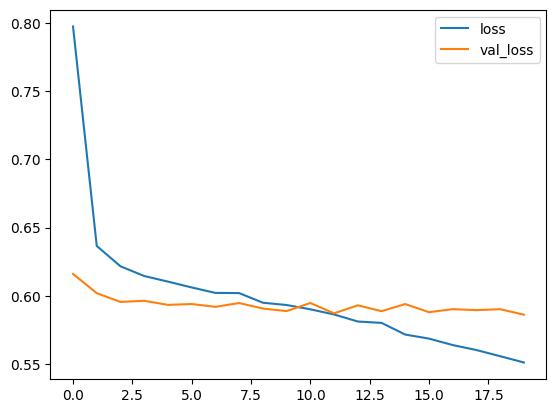

In [81]:
metrics = pd.DataFrame(model_GRU_hist_2.history)
metrics[['loss', 'val_loss']].plot()

mirip dengan model LSTM, model ini juga menggunakan Transfer learning yang sama sehingga performansi nya tidak berbeda jauh

# Model Evaluation

60/60 [==============================] - 1s 1ms/step


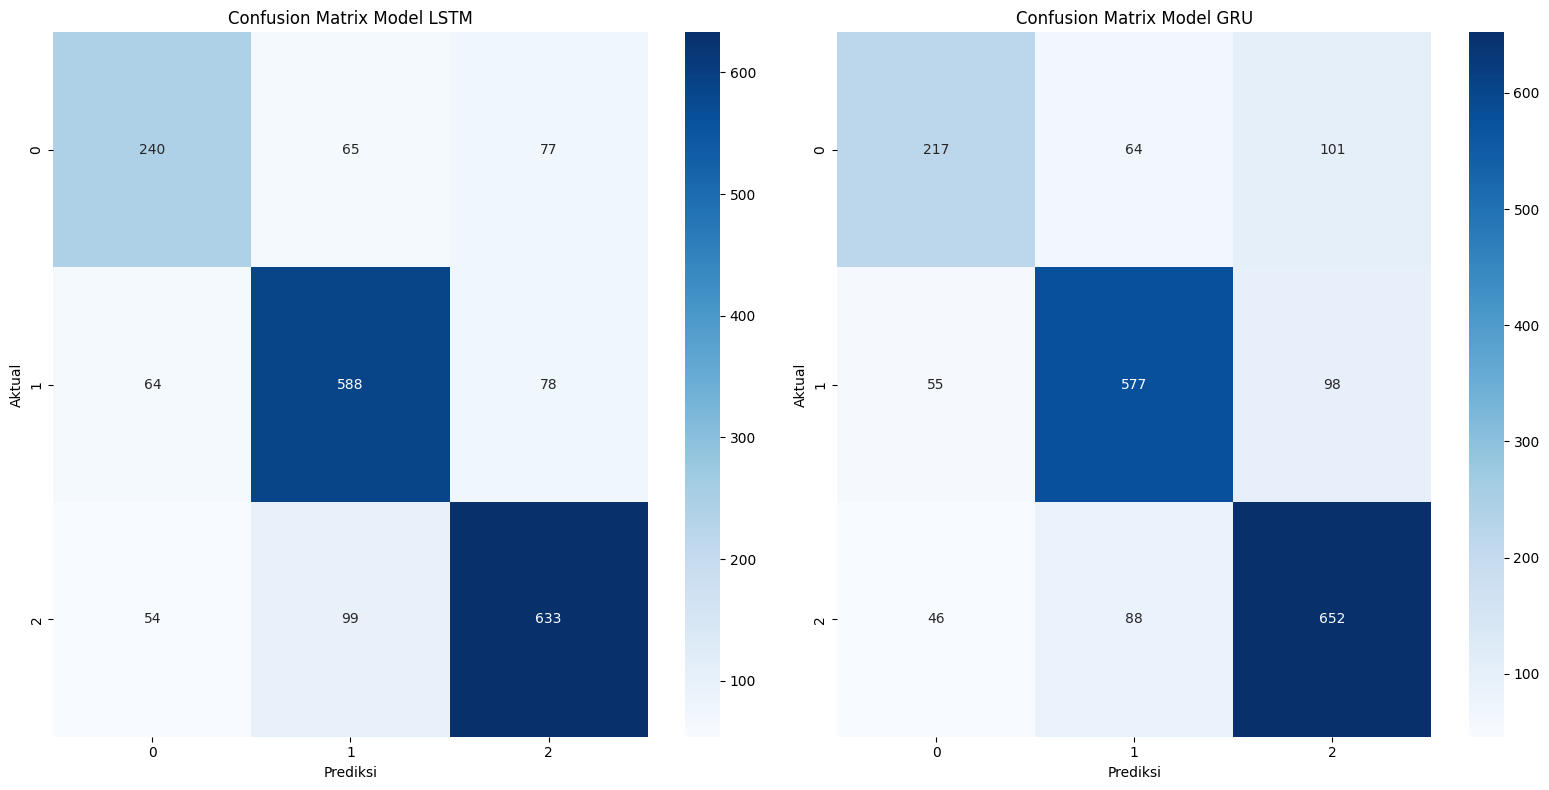

In [82]:
y_pred_lstm = [np.argmax(pred) for pred in model_lstm.predict(X_test)]
y_pred_gru = [np.argmax(pred) for pred in model_GRU.predict(X_test)]
# Hitung confusion matrix
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
cm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix Model LSTM")

# Hitung confusion matrix
plt.subplot(1,2,2)
cma = confusion_matrix(y_test, y_pred_gru)
sns.heatmap(cma, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix Model GRU")
plt.tight_layout()
plt.show()

berdasarkan 2 buah confusion matrix diatas saya memutuskan untuk menggunakan Model LSTM sebagai model terbaik dikarenakan prediksi benar pada model LSTM dan GRU tidak berbeda jauh yaitu 1461   ( LSTM ) dan 1446 ( GRU ) serta pada grafik performansi nya loss dan val-loss dari model LSTM lebih stabil dibandingkan dengan model GRU yang memiliki spike/exploding gradient.

In [83]:
df_eval = pd.concat([X_test,y_test],axis=1)
df_eval['pred'] = y_pred_lstm
df_eval['benar_predict'] = df_eval['sentiment'] == df_eval['pred']
df_eval

,processed_tweet,sentiment,pred,benar_predict
4239,atur syarat pesawat baru ppkm panjang vaksin wajib tes pcr via,1,1,True
5185,warga kota metro dukung penuh sekat titik ruas jalan terap ppkm mikro ketat minimal mobilitas masyarakat,1,1,True
3719,ricuh warna unjuk gelar massa kemudi ojek online pemuda balai kota bandung ricuh duga picu provokasi salah kelompok massa lengkap,1,1,True
5944,ppkm jasa turun tular covid dampak dunia tenaga kerja catat,1,1,True
832,mbak nana,2,2,True
...,...,...,...,...
3562,tahu informasi bagi wilayah jabar dasar level,1,1,True
666,cegah kerumun level makan minum rumah makan batas maksimal menit dengan menit tidak yuk bukti,1,1,True
8545,miskin teriak lapar kaya teriak prokes,2,2,True
6553,perintah antisipasi tingkat konsumsi domestik masyarakat jaga ppkm level panjang agustus bantu sosia,1,1,True


In [84]:
data_benar_prediksi = df_eval[df_eval['benar_predict'] == True]
data_salah_prediksi = df_eval[df_eval['benar_predict'] == False]

In [85]:
data_benar_prediksi

,processed_tweet,sentiment,pred,benar_predict
4239,atur syarat pesawat baru ppkm panjang vaksin wajib tes pcr via,1,1,True
5185,warga kota metro dukung penuh sekat titik ruas jalan terap ppkm mikro ketat minimal mobilitas masyarakat,1,1,True
3719,ricuh warna unjuk gelar massa kemudi ojek online pemuda balai kota bandung ricuh duga picu provokasi salah kelompok massa lengkap,1,1,True
5944,ppkm jasa turun tular covid dampak dunia tenaga kerja catat,1,1,True
832,mbak nana,2,2,True
...,...,...,...,...
3562,tahu informasi bagi wilayah jabar dasar level,1,1,True
666,cegah kerumun level makan minum rumah makan batas maksimal menit dengan menit tidak yuk bukti,1,1,True
8545,miskin teriak lapar kaya teriak prokes,2,2,True
6553,perintah antisipasi tingkat konsumsi domestik masyarakat jaga ppkm level panjang agustus bantu sosia,1,1,True


In [86]:
data_salah_prediksi

,processed_tweet,sentiment,pred,benar_predict
5824,lampor masuk cerita ringan lambat kalau cerita lampor selesai riset moga hibur,2,0,False
3760,yaa ppkm ppkm mari ken pinter kelas matematika,2,0,False
8499,iya cuci tangan pakai masker jaga jarak kurang mobilitas hindar kerumun konsumsi vitamin jaga pola makan istirahat prokes hindar risiko kontak positif covid,1,0,False
7336,versi kalau pliss bera kembar wkwk,1,2,False
4423,ppkm panjang akibat ketidakterlaksanaan proker kknku lomba ppkm saran lomba napas rebah,2,1,False
...,...,...,...,...
9152,muas bisnis perintah,0,1,False
7249,hore gajadi outing kantor pdhl deh saya siapin banget acara bagaimana apadaya manusia rencana allah tentu boboan saja lebih baik skrng mah,2,0,False
7321,perintah strategi capai target vaksinasi tingkat juta dosis target juta dosis capai bius rakyat bahagia semu,2,0,False
6338,siti nadia tarmizi lena level,1,2,False


pada data salah prediksi disini model cenderung sulit untuk memprediksi kalimat yang mengarah pada sarkasme yang artinya jika pada kalimat tersebut terlihat seperti kalimat positif tetapi sebenarnya sentimen nya ialah negatif

# Model Saving

In [87]:
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               112461824 
                                                                 
 reshape_2 (Reshape)         (None, 1, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 32)             20608     
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 112,490,851
Trainable params: 29,027
Non-trainable params: 112,461,824
_________________________________________________________________


In [88]:
model_lstm.trainable=False

In [89]:
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               112461824 
                                                                 
 reshape_2 (Reshape)         (None, 1, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 32)             20608     
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 112,490,851
Trainable params: 0
Non-trainable params: 112,490,851
_________________________________________________________________


In [94]:
model_lstm.save('sentiment_PPKM_NLP_Model.keras')

In [10]:
def function_to_text(function):
    function_source = ast.unparse(ast.parse(inspect.getsource(function)))
    return function_source

# Konversi fungsi ke dalam teks
function_text = function_to_text(formalize_words)


In [98]:
with open('kamus.txt', 'wb') as file_1:
  pickle.dump(kamus, file_1)

with open('text_proses.txt', 'wb') as file_2:
  pickle.dump(text_proses, file_2)

with open('formalize_word.txt', 'wb') as file_3:
  pickle.dump(formalize_words, file_3)

# Summary

Secara keseluruhan, penggunaan model NLP untuk menganalisis sentimen PPKM dapat memberikan manfaat penting dalam memahami persepsi masyarakat dan memberikan wawasan yang berharga bagi pengambilan keputusan dan pengelolaan krisis kesehatan dan sosial selama PPKM. Dalam tahap persiapan data, saya melakukan pembersihan dan preprocessing teks, termasuk tokenisasi, penghapusan stopwords, dan stemming . Selanjutnya, saya membagi data menjadi dataset latih dan dataset uji untuk melatih dan mengevaluasi model.Hasil evaluasi model menunjukkan tingkat akurasi dari model termasuk goodfit di angka 78% dan di validation sebesar 76% . Namun, perlu dicatat bahwa keakuratan model dapat tergantung pada kualitas dan jumlah data latih yang digunakan. Pengumpulan dan pemrosesan data yang lebih representatif dan komprehensif dapat meningkatkan performa model untuk analisis sentimen yang lebih akurat.